In [38]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

pd.set_option('display.max_columns', None)

In [39]:
import pandas as pd
import numpy as np

# 1) Reload clean
df = pd.read_csv("Radiohead Setlists 2025 - tracking.csv")

# 2) Use first row as header
df.columns = df.iloc[0]
df = df.drop(index=0).reset_index(drop=True)

# 3) Clean column names (handles weird spaces / NaNs)
df.columns = pd.Index(df.columns).map(lambda x: "" if pd.isna(x) else str(x).strip())

# If the first column header became empty, it's usually the album column
if df.columns[0] == "":
    df = df.rename(columns={df.columns[0]: "album"})

# 4) Standardize the key columns (case/spacing safe)
rename_map = {}
for c in df.columns:
    if c.strip().lower() == "song":
        rename_map[c] = "song"
    if c.strip().lower() == "count":
        rename_map[c] = "total_count"
df = df.rename(columns=rename_map)

# 5) Confirm we have what we need
print("Columns now include:", [c for c in ["album","song","total_count"] if c in df.columns])

# 6) Build melt columns
meta_cols = [c for c in ["album","song","total_count"] if c in df.columns]
concert_cols = [c for c in df.columns if c not in meta_cols]

# 7) Melt
long_df = df.melt(
    id_vars=meta_cols,
    value_vars=concert_cols,
    var_name="concert",
    value_name="position"
).dropna(subset=["position"])

# 8) Make positions numeric
long_df["position"] = pd.to_numeric(long_df["position"], errors="coerce")
long_df = long_df.dropna(subset=["position"])
long_df["position"] = long_df["position"].astype(int)

long_df.head()

Columns now include: ['album', 'song', 'total_count']


,album,song,total_count,concert,position
0,The Bends,Fake Plastic Trees,11,4.11.,19
7,OK Computer,Let Down,20,4.11.,1
8,OK Computer,Paranoid Android,20,4.11.,21
9,OK Computer,Lucky,10,4.11.,5
10,OK Computer,No Surprises,19,4.11.,9


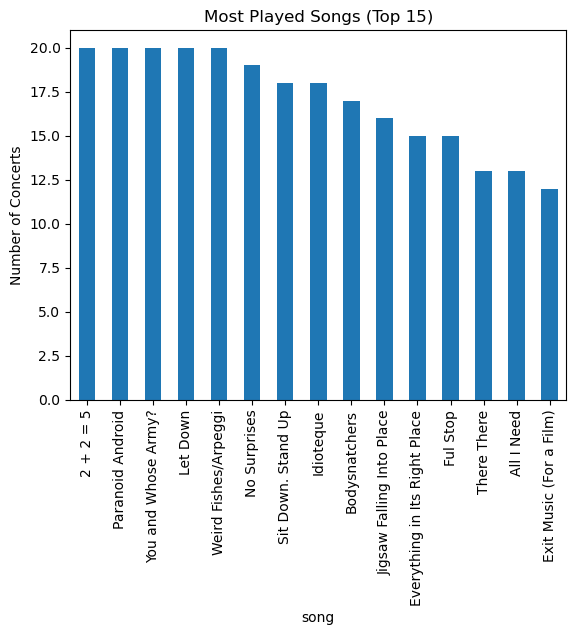

In [40]:
song_freq = long_df["song"].value_counts()

song_freq.head(10)


song_freq.head(15).plot(kind="bar")
plt.title("Most Played Songs (Top 15)")
plt.ylabel("Number of Concerts")
plt.show()

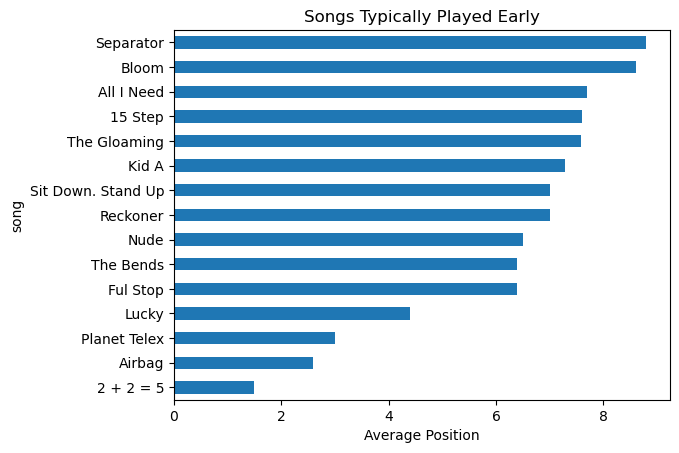

In [41]:
avg_position = (
    long_df
    .groupby("song")["position"]
    .mean()
    .sort_values()
)

avg_position.head(10)


avg_position.head(15).plot(kind="barh")
plt.title("Songs Typically Played Early")
plt.xlabel("Average Position")
plt.show()

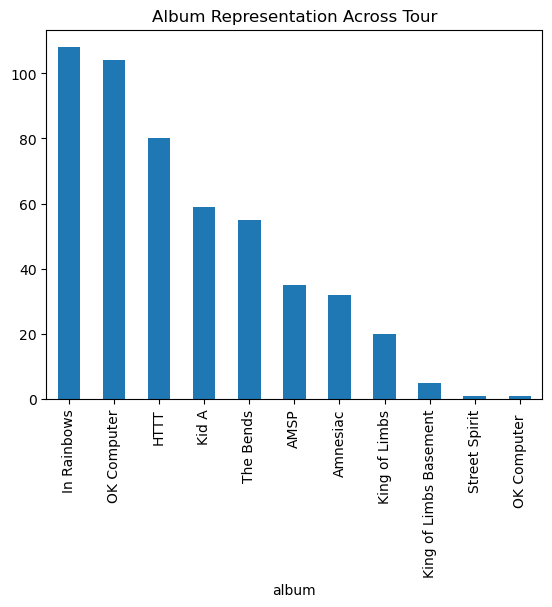

In [43]:
df["album"] = df.iloc[:, 0]


long_df = long_df.merge(
    df[["song", "album"]],
    on="song",
    how="left"
)

long_df["album"].value_counts().plot(kind="bar")
plt.title("Album Representation Across Tour")
plt.show()

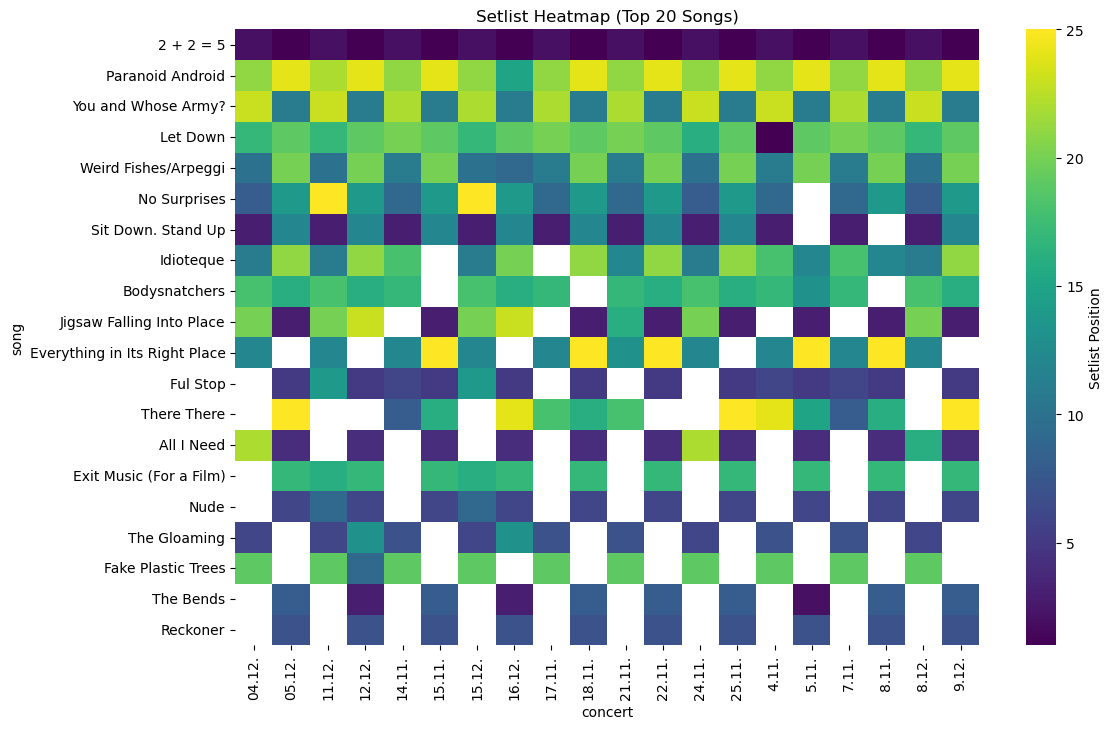

In [44]:
heatmap_df = long_df.pivot(
    index="song",
    columns="concert",
    values="position"
)


top_songs = song_freq.head(20).index

plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_df.loc[top_songs],
    cmap="viridis",
    cbar_kws={"label": "Setlist Position"}
)
plt.title("Setlist Heatmap (Top 20 Songs)")
plt.show()

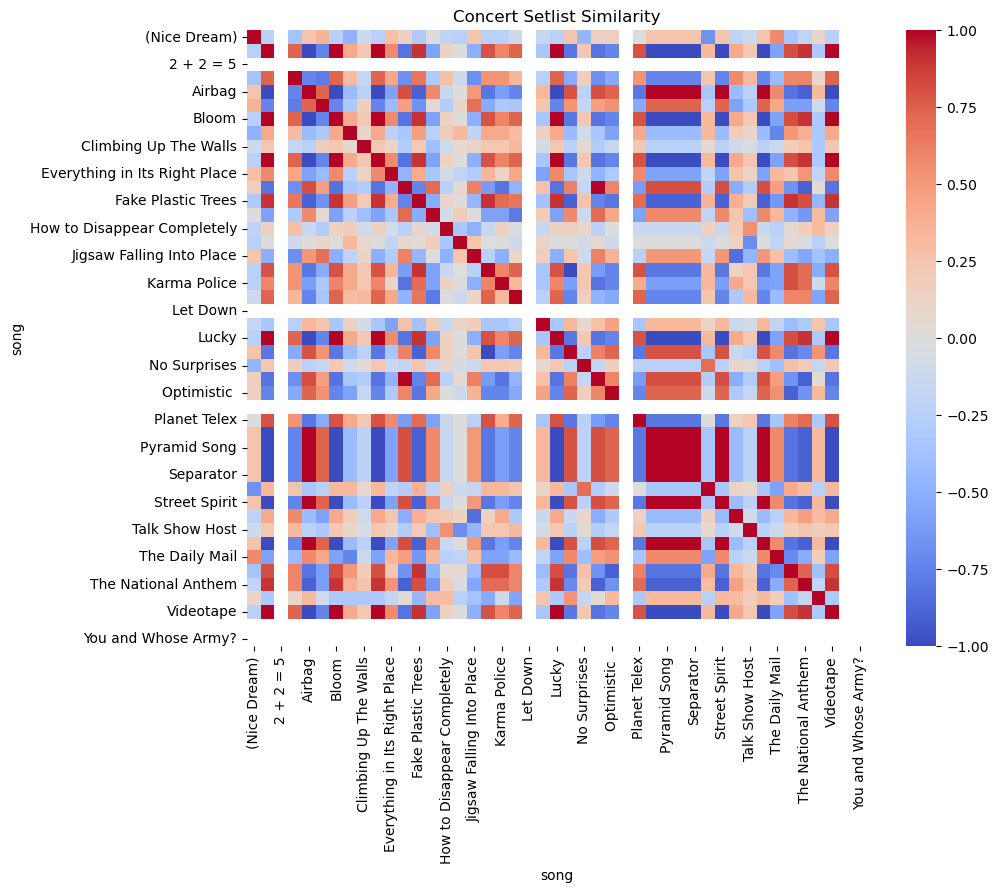

In [45]:
binary_df = heatmap_df.notna().astype(int)

similarity = binary_df.T.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(similarity, cmap="coolwarm")
plt.title("Concert Setlist Similarity")
plt.show()